### 필요 라이브러리

In [ ]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose # 시계열 데이터 분해 라이브러리

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/lg-aimers-data/train/train.csv'
TEST_PATH = '/content/drive/MyDrive/lg-aimers-data/test/TEST_00.csv'

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

## 데이터셋 EDA

### 기본 데이터 파악

In [ ]:
train = train.rename(columns={
    '영업일자': 'date',
    '영업장명_메뉴명': 'store_menu',
    '매출수량': 'sales_qty'
})

train['date'] = pd.to_datetime(train['date'])
train['store'] = train['store_menu'].str.split('_').str[0]
train['menu'] = train['store_menu'].str.split('_').str[1]

In [ ]:
train.head()

,date,store_menu,sales_qty,store,menu
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트


In [ ]:
stores = train['store'].unique()

In [ ]:
store_menu = train['store_menu'].unique()
data = train[train['store_menu'] == store_menu[0]].copy()

In [ ]:
data

,date,store_menu,sales_qty,store,menu
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
...,...,...,...,...,...
527,2024-06-11,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
528,2024-06-12,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
529,2024-06-13,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트
530,2024-06-14,느티나무 셀프BBQ_1인 수저세트,16,느티나무 셀프BBQ,1인 수저세트


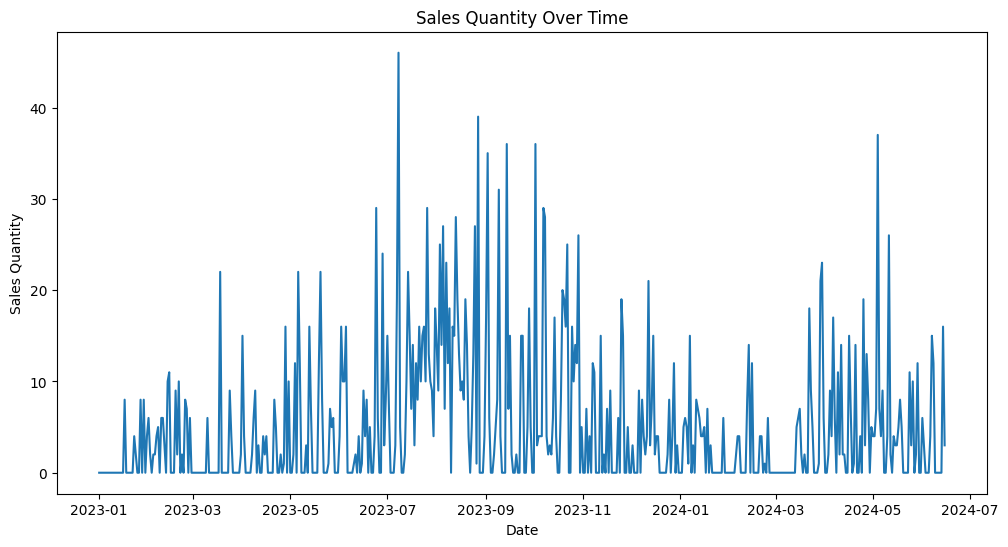

In [ ]:
# 시계열 라인 플롯 (시간 흐름 시각화)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['date'], data['sales_qty'])
plt.title('Sales Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.show()

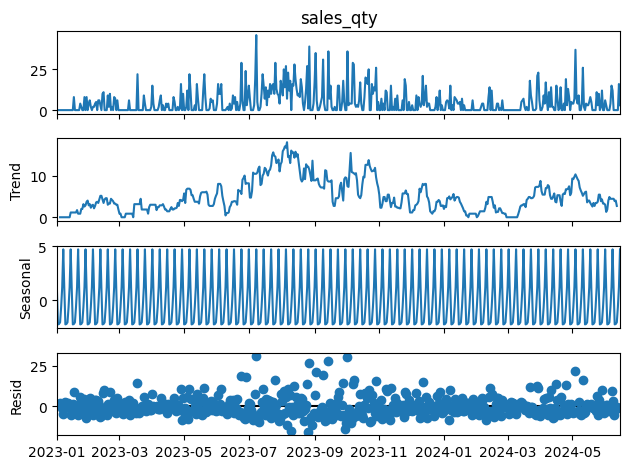

In [ ]:
# 계절성 분해 그래프 (trend, seasonal, residual 분리)
"""
1. Trend: 데이터가 시간에 따라 전반적으로 증가하거나 감소하는 패턴
예를 들어,, 장기적으로 매출이 늘어난다거나 하는 거임! 작은 변동 무시하고 전체 흐름만

2. Seasonal: 일정한 주기로 반복되는 패턴!!
예를 들어, 요일별 매출 차이나 월별 판매량 차이 같은거 있잖아
주말 매출이 평일보다 적거나, 특정 계절에 매출이 올라가는 식이 해당

3. Residual: 추세와 계절성을 제거하고 남은 부분으로, 예측하기 힘든 불규칙한 변동
이걸로 이제 이상치 탐지해야해 뭐 이벤트라던가 날씨라던가..
"""
# 일다는 일별 데이터라 요일별로 seasonal 특징이 있다치고 period=7로 한거임
from statsmodels.tsa.seasonal import seasonal_decompose

daily_sales = data.groupby('date')['sales_qty'].sum()
# daily_sales = data.resample('W', on='date')['sales_qty'].sum() # 주 매출
result = seasonal_decompose(daily_sales, model='additive', period=7)
result.plot()
plt.show()

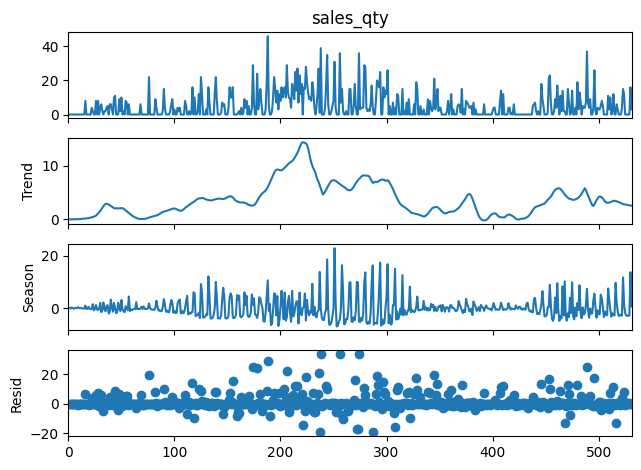

In [ ]:
from statsmodels.tsa.seasonal import STL # 얘가 더 좋다는데?

df = data.copy()
target_col='sales_qty'
period=7

stl = STL(df[target_col], period=period, robust=True)
res = stl.fit()
df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['residual'] = df[target_col] - (df['trend'] + df['seasonal'])

res.plot()
plt.show()

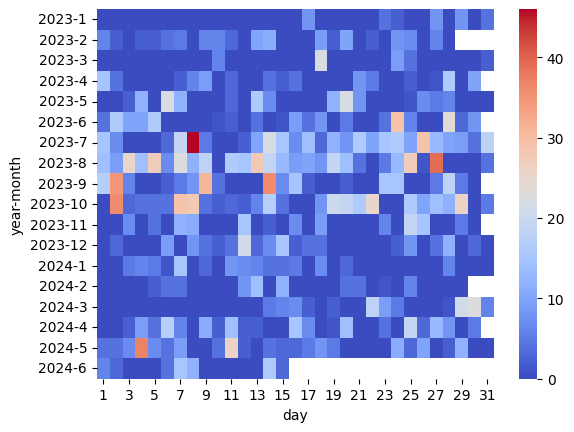

In [ ]:
# Heatmap (Seasonal Calendar Plot) 연/월/요일별 패턴을 시각적으로 한 번에 확인

daily_df = daily_sales.to_frame(name='sales')
daily_df['day'] = daily_df.index.day
daily_df['month'] = daily_df.index.month
daily_df['year'] = daily_df.index.year # Add year column
pivot = daily_df.pivot_table(index=['year', 'month'], columns='day', values='sales') # Use pivot_table with multiple index levels
sns.heatmap(pivot, cmap='coolwarm')
plt.show()

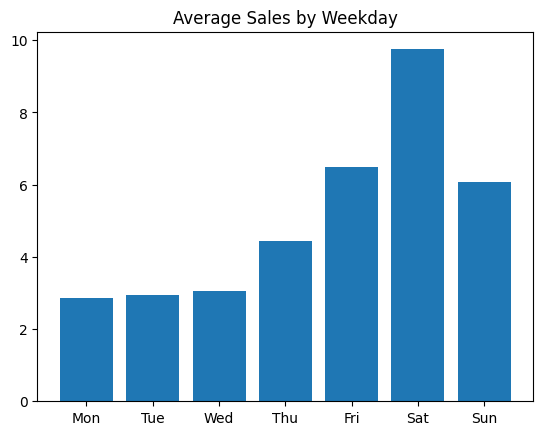

In [ ]:
# 요일별 평균 시계열 (요일별 패턴)
data['weekday'] = data['date'].dt.weekday  # 월=0, 일=6
weekday_avg = data.groupby('weekday')['sales_qty'].mean()

plt.bar(weekday_avg.index, weekday_avg.values)
plt.xticks(ticks=range(7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Average Sales by Weekday')
plt.show()

이 분해(STL/seasonal_decompose) 결과를 트랜스포머에 넣는 방법은 크게 3가지 패턴이 있어요. 목적은 “모델이 어려운 것(잔차)을 배우게 하고, 쉬운 것(계절·추세)은 우리가 제공”하는 겁니다.

In [ ]:
trend = result.trend.dropna()
trend_variance = trend.var()
original_variance = daily_sales.var()

if trend_variance / original_variance > 0.1:  # 예시 임계값
    print("뚜렷한 트렌드 존재")
else:
    print("트렌드 영향 적음")

뚜렷한 트렌드 존재


### 먼저 시즌성을 판단해보자

| ACF에서 보는 것                  | 의미               | 피처화 아이디어                      |
| --------------------------- | ---------------- | ----------------------------- |
| lag 1, 2, 3 등 짧은 시차에서 상관 높음 | 단기 영향 강함         | 최근 몇 일 매출 값이나 이동평균 등 넣기       |
| lag 7, 14, 21 등 7일 간격 피크    | 주간 주기성 강함        | 요일(day\_of\_week), 주 단위 지표 넣기 |
| lag 30, 60 등 긴 시차 피크        | 월간 또는 월말 등 장기 패턴 | 월(month), 분기(quarter) 등 넣기    |

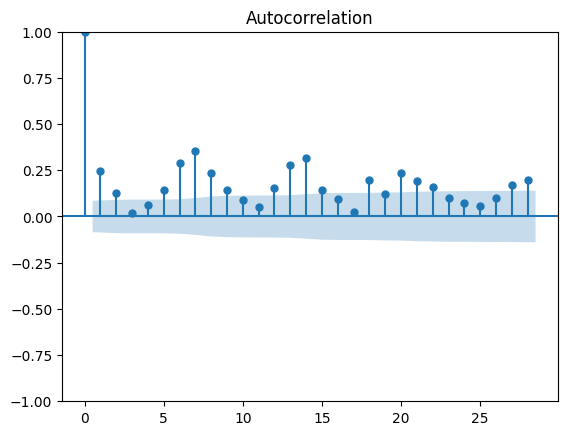

In [ ]:
# 자기상관함수(ACF) 플롯 => 얼마나 과거랑 관계가 있는지
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(daily_sales, lags=28)
plt.show()
# 대충 보니까 7일 간격으로 반복되긴 하네

<Axes: xlabel='y(t)', ylabel='y(t + 7)'>

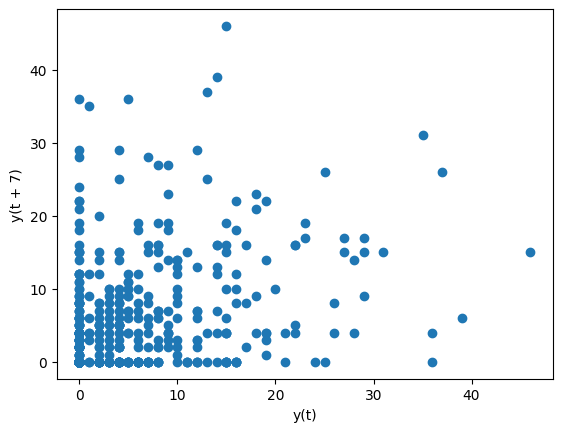

In [ ]:
# Lag Plot: lag와 현재 값의 관계를 산점도로 확인 7일 주기가 있다면 lag=7에서 점들이 대각선에 가까워짐.
from pandas.plotting import lag_plot
lag_plot(daily_sales, lag=7)

### 이제 트렌드!!! 파악해보자구~~!!

1. Rolling Mean (이동 평균) : 최근 7일 간 평균 판매량이 어떻게 변하는지 보여줌
- 값이 높아지면 최근 1주일 동안 판매량이 전반적으로 많았다는 뜻
- 예를 들어 2023년 7~9월에 파란선이 높게 유지 → 여름 시즌에 매출 상승

2. Rolling Std (이동 표준편차) : 최근 7일 동안 판매량의 변동성이 얼마나 큰지
- 값이 높으면 하루하루 매출이 크게 들쑥날쑥했다는 뜻
- 예를 들어 여름철(7~9월)에 주황선이 높음 → 매출이 많긴 한데, 하루별로 차이가 큼 (프로모션, 주말효과 등 가능성)

3. 둘의 관계
- 평균과 표준편차가 같이 높아지면: "많이 팔리지만 불안정함" (성수기 + 이벤트성 매출)
- 평균은 높지만 표준편차는 낮으면: "꾸준히 잘 팔림" (안정적인 인기 상품/시즌)
- 평균과 표준편차가 같이 낮아지면: "비성수기"

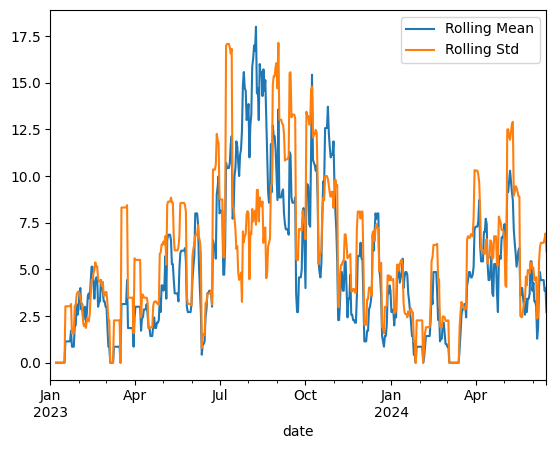

In [ ]:
# Rolling Mean & Rolling Std (이동평균/표준편차) 추세와 변동성을 동시에 확인 가능
window = 7
daily_sales.rolling(window).mean().plot(label='Rolling Mean')
daily_sales.rolling(window).std().plot(label='Rolling Std')
plt.legend()
plt.show()

In [ ]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.0 MB/s eta 0:00:00


<class 'list'>


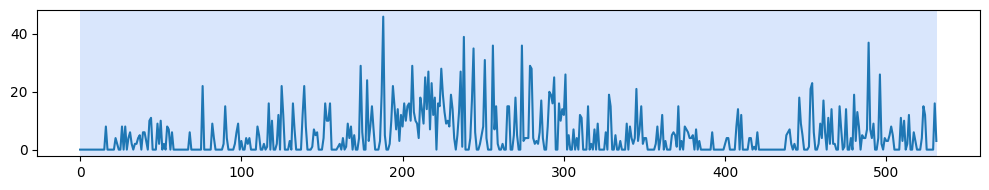

In [ ]:
# Change Point Detection Plot 트렌드나 분산이 바뀌는 지점(프로모션, 이벤트 등)을
# 흠 근데 얘는 어케 활용할지는 모르겟네 rolling_std랑 걍 거의 비슷한거같은데
import ruptures as rpt
algo = rpt.Pelt(model="rbf").fit(daily_sales.values)
result_CPD = algo.predict(pen=10) # pen이 커지면 큰 변화만 잡음
rpt.display(daily_sales.values, result_CPD)
print(type(result_CPD))
plt.show()

### 흠냐... residual을 예측하기 위해선 어떤 flag가 있어야할까?
- 일단 요일, 주차, 월 등을 넣자! 얘넨 트랜스포머가 "이 시점이 어떤 컨텍스트인지” 파악하는 데 도움됨
- 그리고 lag=7이랑 rolling을 넣도록 하자! 얘네 시즌,트렌드랑 비슷해보이지만 잔차 계산할 때 도움을 주겠지
- event = 1? holiday=1? 등등 추가해서 컨텍스트 최대화 해보자

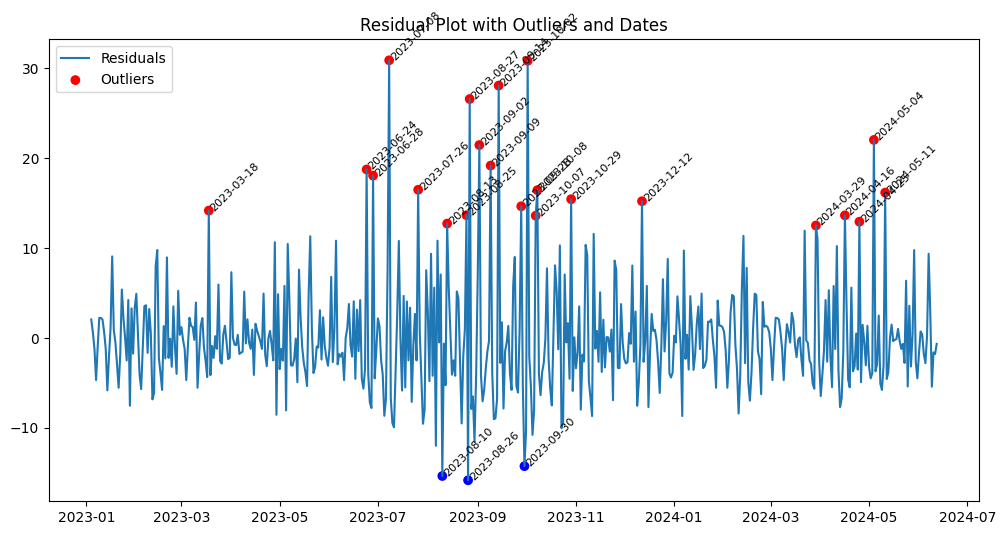

In [ ]:
# 잔차 그래프만 볼건데
resid = result.resid
plt.figure(figsize=(12,6))
plt.plot(resid, label='Residuals')

# 이상치 조건 (예: 잔차 절댓값이 평균 + 2*std 이상인 경우)
threshold = resid.mean() + 2*resid.std()
outliers = np.abs(resid) > threshold

outliers_plus = resid > threshold # np.abs(resid)
outliers_minus = -resid > threshold
pos_date = []
neg_date = []

# 이상치 표시
plt.scatter(resid.index[outliers],
            resid[outliers],
            color=['red' if r > 0 else 'blue' for r in resid[outliers]],
            label='Outliers')

# 이상치에 날짜 표시
for date in resid.index[outliers]:
    plt.text(date, resid[date], str(date.date()), fontsize=8, rotation=45)
    if (resid[date] >= 0):
        pos_date.append(date)
    else:
        neg_date.append(date)

plt.title("Residual Plot with Outliers and Dates")
plt.legend()
plt.show()

In [ ]:
import holidays

kr_holidays = holidays.KR(years=pos_date[0].year)  # sp_date에 데이터 있다고 가정

print("이상치 양수")
for date in pos_date:
    if date in kr_holidays:
        print(f"{date} 는 공휴일: {kr_holidays[date]}")
    elif date.weekday() >= 5:
        print(f"{date} 는 주말: {date.strftime('%A')}")
    else:
        print(f"{date} 는 평일: {date.strftime('%A')}")

print("\n이상치 음수")
for date in neg_date:
    if date in kr_holidays:
        print(f"{date} 는 공휴일: {kr_holidays[date]}")
    elif date.weekday() >= 5:
        print(f"{date} 는 주말: {date.strftime('%A')}")
    else:
        print(f"{date} 는 평일: {date.strftime('%A')}")

이상치 양수
2023-03-18 00:00:00 는 주말: Saturday
2023-06-24 00:00:00 는 주말: Saturday
2023-06-28 00:00:00 는 평일: Wednesday
2023-07-08 00:00:00 는 주말: Saturday
2023-07-26 00:00:00 는 평일: Wednesday
2023-08-13 00:00:00 는 주말: Sunday
2023-08-25 00:00:00 는 평일: Friday
2023-08-27 00:00:00 는 주말: Sunday
2023-09-02 00:00:00 는 주말: Saturday
2023-09-09 00:00:00 는 주말: Saturday
2023-09-14 00:00:00 는 평일: Thursday
2023-09-28 00:00:00 는 공휴일: The day preceding Chuseok
2023-10-02 00:00:00 는 공휴일: Temporary Public Holiday
2023-10-07 00:00:00 는 주말: Saturday
2023-10-08 00:00:00 는 주말: Sunday
2023-10-29 00:00:00 는 주말: Sunday
2023-12-12 00:00:00 는 평일: Tuesday
2024-03-29 00:00:00 는 평일: Friday
2024-04-16 00:00:00 는 평일: Tuesday
2024-04-25 00:00:00 는 평일: Thursday
2024-05-04 00:00:00 는 주말: Saturday
2024-05-11 00:00:00 는 주말: Saturday

이상치 음수
2023-08-10 00:00:00 는 평일: Thursday
2023-08-26 00:00:00 는 주말: Saturday
2023-09-30 00:00:00 는 공휴일: The second day of Chuseok


흠.... 일단 주말에 긍정적인 이상치가 많고,,,, 공휴일마다 또 이상치가 생기니까 is_weekend 변수로 걍 월화수목금토일 구분에 더해 강조를 한번 더 하고,, 그러고 공휴일 정보나 시즌 정보 같은거 one-hot으로 넣든가 하자! 근데 이건 좀 고민이긴해

### 모든 메뉴의 시즌성을 한번 파악해보자

- Mean↑ + Std↑: 시즌성
- Mean↑ + Std↓: 비시즌적
- Mean≈ + Std↑: 이벤트성 튐

In [ ]:
stores

array(['느티나무 셀프BBQ', '담하', '라그로타', '미라시아', '연회장', '카페테리아', '포레스트릿',
       '화담숲주막', '화담숲카페'], dtype=object)

In [ ]:
# store = stores[4]
# # store_menu = train['store_menu'].unique()
# data1 = train[train['store'] == store].copy()

# for menu in data1['menu'].unique():
#   data2 = data1[data1['menu'] == menu].copy()
#   daily_sales = data2.groupby('date')['sales_qty'].sum()
#   print(menu)
#   window = 28
#   daily_sales.rolling(window).mean().plot(label='Rolling Mean')
#   daily_sales.rolling(window).std().plot(label='Rolling Std')
#   plt.legend()
#   plt.show()

아 귀찮으니까 걍 std가 높은 날은 어쨌든 시즌이거나 이벤트일거니까 is_event 이렇게만 넣자! is_summer_peak 이런건 내 생각으론 trend 얘로도 구분할 수 있을듯 아님말고

In [ ]:
def _label_one(g, window=28):
    # 일자 집계 → 정렬
    df = (g.groupby('date', as_index=False)['sales_qty'].sum()
            .sort_values('date').rename(columns={'sales_qty':'y'}))
    minp = max(3, window//2)

    # rolling mean / std (trailing)
    df['roll_mean'] = df['y'].rolling(window, min_periods=minp).mean()
    df['roll_std']  = df['y'].rolling(window, min_periods=minp).std(ddof=0)

    # 이벤트성 변동: rolling std가 상위 퍼센타일 이상인 구간
    s_hi = df['roll_std'].quantile(0.70)  # 70% 퍼센타일
    df['is_eventy_volatile'] = (df['roll_std'] >= s_hi).astype(int)

    # # ── IQR 이상치 (raw y)
    # q1 = df['y'].rolling(window, min_periods=minp).quantile(0.25)
    # q3 = df['y'].rolling(window, min_periods=minp).quantile(0.75)
    # iqr = q3 - q1
    # lower = q1 - iqr_k*iqr
    # upper = q3 + iqr_k*iqr
    # df['is_upper_outlier'] = (df['y'] > upper).astype(int)
    # df['is_lower_outlier'] = (df['y'] < lower).astype(int)
    # df['is_outlier'] = df[['is_upper_outlier','is_lower_outlier']].max(axis=1)

    # 식별자
    df['store'] = g['store'].iloc[0]
    df['menu']  = g['menu'].iloc[0]
    return df

# ── 사용
store = stores[4]
WINDOW = 28

data = train.loc[train['store']==store, ['store','menu','date','sales_qty']].copy()
data['date'] = pd.to_datetime(data['date'])

labeled_all = (data.groupby('menu', group_keys=False)
                    .apply(_label_one, window=WINDOW)
                    .reset_index(drop=True))

/tmp/ipython-input-3617352579.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_label_one, window=WINDOW)


### 클러스터링 관련

In [ ]:
store = stores[0]

store_df = train[train['store'] == store]
daily_store_sales = store_df.groupby('date')['sales_qty'].sum() # 하루 매출
weekly_sales = store_df.resample('W', on='date')['sales_qty'].sum() # 주 매출

top_menu = store_df.groupby('menu')['sales_qty'].sum().nlargest(5).index # 관심메뉴(판매량 top 5)
filtered = store_df[store_df['menu'].isin(top_menu)] # 관심메뉴만 있는 데이터셋

In [ ]:
def day_fav(df):
  for date, group_df in df.groupby('date'):
    top_menu = group_df.groupby('menu')['sales_qty'].sum().nlargest(5).index.tolist()
    print(f"{date}: {top_menu}")

def week_fav(df):
  df['week'] = df['date'].dt.isocalendar().week
  df['year'] = df['date'].dt.year

  for (year, week), group_df in df.groupby(['year', 'week']):
      top_menu = group_df.groupby('menu')['sales_qty'].sum().nlargest(5).index.tolist()
      print(f"{year}.{week}주: {top_menu}")

def month_fav(df):
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year  # 연도 필수!

  for (year, month), group_df in df.groupby(['year', 'month']):
      top_menu = group_df.groupby('menu')['sales_qty'].sum().nlargest(5).index.tolist()
      print(f"{year}.{month}월: {top_menu}")


In [ ]:
stores = train['store'].unique()

for store_name, group_df in train.groupby('store'):
  if store_name == stores[0]:
    print(store_name)
    # print(f"전체메뉴 {group_df.menu.unique()}")

    top_menu = group_df.groupby('menu')['sales_qty'].sum().nlargest(5).index.tolist() # 관심메뉴(판매량 top 5)
    print(f"관심메뉴 {top_menu}")
    week_fav(group_df)
    month_fav(group_df)

    filtered = group_df[group_df['menu'].isin(top_menu)] # 관심메뉴만 있는 데이터셋
    print("")

느티나무 셀프BBQ
관심메뉴 ['카스 병(단체)', 'BBQ55(단체)', '참이슬 (단체)', '잔디그늘집 대여료 (6인석)', '콜라 (단체)']
2023.1주: ['카스 병(단체)', '콜라 (단체)', '대여료 30,000원', '스프라이트 (단체)', '참이슬 (단체)']
2023.2주: ['대여료 30,000원', '카스 병(단체)', '스프라이트 (단체)', '콜라 (단체)', '대여료 60,000원']
2023.3주: ['BBQ55(단체)', '대여료 60,000원', '대여료 30,000원', '카스 병(단체)', '참이슬 (단체)']
2023.4주: ['카스 병(단체)', '참이슬 (단체)', '스프라이트 (단체)', '콜라 (단체)', '대여료 30,000원']
2023.5주: ['카스 병(단체)', '참이슬 (단체)', 'BBQ55(단체)', '콜라 (단체)', '스프라이트 (단체)']
2023.6주: ['카스 병(단체)', '대여료 30,000원', '1인 수저세트', '대여료 60,000원', '참이슬 (단체)']
2023.7주: ['카스 병(단체)', '참이슬 (단체)', '콜라 (단체)', '스프라이트 (단체)', '1인 수저세트']
2023.8주: ['카스 병(단체)', '콜라 (단체)', '스프라이트 (단체)', '참이슬 (단체)', '대여료 30,000원']
2023.9주: ['대여료 30,000원', '1인 수저세트', '대여료 60,000원', '친환경 접시 23cm', '일회용 소주컵']
2023.10주: ['BBQ55(단체)', '스프라이트 (단체)', '콜라 (단체)', '참이슬 (단체)', '카스 병(단체)']
2023.11주: ['BBQ55(단체)', '카스 병(단체)', '참이슬 (단체)', '콜라 (단체)', '스프라이트 (단체)']
2023.12주: ['BBQ55(단체)', '참이슬 (단체)', '카스 병(단체)', '스프라이트 (단체)', '콜라 (단체)']
2023.13주: ['BBQ55(단체)', '참이

### 아래처럼 트랜스포머 모델 속에 임베딩 넣도록 하자

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL

# ── 1) 한 시계열을 T+S 분해하고 residual + 이벤트/이상치 플래그 생성
def residual_feats_one(df, date_col='date', y_col='sales_qty',
                       stl_period=7, window=28, std_q=0.70, iqr_k=1.5):
    """
    입력 df: 단일 시계열(한 store-한 menu)만 들어오게 필터한 뒤 호출
    반환: 날짜별 [y, trend, seasonal, residual, roll_std, is_eventy_volatile, is_outlier]
    """
    d = (df[[date_col, y_col]].copy()
           .groupby(date_col, as_index=False)[y_col].sum()
           .sort_values(date_col))
    d[date_col] = pd.to_datetime(d[date_col])
    d = d.set_index(date_col)

    # --- T+S 분해 (STL; 주간 계절성이면 period=7)
    # robust=True로 이벤트 구간의 영향 완화
    stl = STL(d[y_col].astype(float), period=stl_period, robust=True)
    res = stl.fit()
    d['trend']    = res.trend
    d['seasonal'] = res.seasonal
    d['residual'] = d[y_col] - (d['trend'] + d['seasonal'])

    # --- 잔차 기반 보조 피처 (모두 trailing)
    minp = max(3, window//2)
    d['roll_std'] = d['residual'].rolling(window, min_periods=minp).std(ddof=0)

    # 이벤트성 변동 flag (상대 기준: 상위 퍼센타일)
    std_thr = d['roll_std'].quantile(std_q)
    d['is_eventy_volatile'] = (d['roll_std'] >= std_thr).astype(int)

    # IQR 이상치 flag (잔차에 대해)
    q1 = d['residual'].rolling(window, min_periods=minp).quantile(0.25)
    q3 = d['residual'].rolling(window, min_periods=minp).quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr_k * iqr
    upper = q3 + iqr_k * iqr
    d['is_outlier'] = ((d['residual'] < lower) | (d['residual'] > upper)).astype(int)

    return d.reset_index()

# ── 2) 매장 하나의 모든 메뉴에 적용 (잔차만 Transformer에 줄 경우 유용)
def build_residual_features(train, store_value,
                            stl_period=7, window=28, std_q=0.70, iqr_k=1.5):
    out = []
    sub = train[train['store'] == store_value].copy()
    sub['date'] = pd.to_datetime(sub['date'])
    for menu, g in sub.groupby('menu'):
        df = residual_feats_one(g, date_col='date', y_col='sales_qty',
                                stl_period=stl_period, window=window,
                                std_q=std_q, iqr_k=iqr_k)
        df['store'] = store_value
        df['menu']  = menu
        out.append(df)
    return pd.concat(out, ignore_index=True)

# ── 사용 예시
# store = stores[4]
# feats = build_residual_features(train, store_value=store,
#                                 stl_period=7, window=28, std_q=0.70, iqr_k=1.5)

# 이제 Transformer 입력에는 주로 다음 컬럼을 사용:
#  - past targets: residual (라그/롤링은 residual 기준으로 생성)
#  - helper feats: roll_std, is_eventy_volatile, is_outlier
#  - (선택) 요일/연중일 sin/cos 등 최소 캘린더 피처

In [ ]:
"""
연중일(sin/cos) 얘도 해야한다네?
왜냐면 봐 1월 1일이랑 12월 31일이랑은 하루차인데
환산하면 1이랑 365일이 되니까 차이 개커보이잖아
"""

# object였던 영업일자를 datetime으로 바꾸자
def add_time_features(df):
    df['year'] = df['date'].dt.year
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['dow'] = df['date'].dt.weekday # 월=0, ..., 일=6
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    return df

# ++ 그 datetime을 요일,일,월으로
data = train.copy()
data['date'] = pd.to_datetime(train['date'])
data = add_time_features(data)

store_le = LabelEncoder()
menu_le = LabelEncoder()
le = LabelEncoder()

data['store'] = store_le.fit_transform(train['store'])
data['menu'] = menu_le.fit_transform(train['menu'])
data['store_menu'] = le.fit_transform(train['store_menu'])

In [ ]:
# df['sales_lag_7'] = df['sales'].shift(7)
# df['sales_lag_14'] = df['sales'].shift(14)

# window = 7
# df['rolling_mean_7'] = df['sales'].rolling(window).mean()
# df['rolling_std_7'] = df['sales'].rolling(window).std()
# dow_mean_7 = mean(y_{t-7k}, k=1..K) # 이렇게 같은 요일 평균도 넣어버릴까

In [ ]:
# import torch.nn as nn

# num_categories = len(store_le.classes_)  # 범주 수
# embedding_dim = 16  # 임베딩 차원 수

# embedding_layer = nn.Embedding(num_categories, embedding_dim)

In [ ]:
# import torch
# import torch.nn as nn

# class MyTransformerModel(nn.Module):
#     def __init__(self, num_store_categories, store_emb_dim, ...):
#         super().__init__()
#         # store 임베딩 레이어
#         self.store_embedding = nn.Embedding(num_store_categories, store_emb_dim)

#         # 예: menu 임베딩도 따로 둔다면
#         # self.menu_embedding = nn.Embedding(num_menu_categories, menu_emb_dim)

#         # ... 기타 트랜스포머 모듈들, 피드포워드 등 정의

#     def forward(self, store_idx, ...):
#         # store_idx: (batch_size, seq_len) 등 인덱스 텐서
#         store_emb = self.store_embedding(store_idx)  # (batch, seq_len, store_emb_dim)

#         # 다른 임베딩 및 입력 벡터와 concat 혹은 합쳐서 transformer에 입력

#         # ... 트랜스포머 forward 연산
#         return output

딥러닝(Transformer, LSTM 등)에서는
Permutation Importance: 한 피처를 무작위 섞어서 성능 변화 확인

SHAP 값: 각 피처가 예측에 기여하는 크기 계산

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_val, y_val, n_repeats=5, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

for idx in sorted_idx:
    print(X_val.columns[idx], result.importances_mean[idx])

NameError: name 'model' is not defined

### 예시 흐름 (28일 → 7일 예측)
1. Trend: 30일 causal rolling mean → 선형회귀로 7일 외삽

2. Seasonal: Fourier(7) + Fourier(14)로 주기 생성 → 미래 7일 그대로 생성

3. Residual:

- 타깃 = y - trend - seasonal

- 입력 = 과거 28일 residual + lag, 요일, rolling_std, CPD 등

- 트랜스포머가 7일 잔차 예측

4 합치기:
`y_hat = resid_hat + trend_future + seasonal_future`

✅ 이 구조는 시계열 대회(캐글)나 실무에서 멀티모델 앙상블의 기본 패턴이에요.
규칙적인 건 규칙적으로, 나머지만 복잡 모델에 맡기는 거죠.